## Census Profile Analysis

### Spark Inicialization

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CensoPySpark") \
    .getOrCreate()

25/03/31 20:13:43 WARN Utils: Your hostname, MacBook-Pro-de-Leticia.local resolves to a loopback address: 127.0.0.1; using 192.168.0.220 instead (on interface en0)
25/03/31 20:13:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/31 20:13:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read Database

In [2]:
df = spark.read.csv("../data/adult-preprocessed.data", header=False, inferSchema=True)
df.show(5)

+---+----------------+------+---------+---+------------------+-----------------+-------------+-----+------+----+----+----+-------------+-----+
|_c0|             _c1|   _c2|      _c3|_c4|               _c5|              _c6|          _c7|  _c8|   _c9|_c10|_c11|_c12|         _c13| _c14|
+---+----------------+------+---------+---+------------------+-----------------+-------------+-----+------+----+----+----+-------------+-----+
| 39|       State-gov| 77516|Bachelors| 13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|2174|   0|  40|United-States|<=50K|
| 50|Self-emp-not-inc| 83311|Bachelors| 13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|   0|   0|  13|United-States|<=50K|
| 38|         Private|215646|  HS-grad|  9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|   0|   0|  40|United-States|<=50K|
| 53|         Private|234721|     11th|  7|Married-civ-spouse|Handlers-cleaners|      Husband|Black|  Male|   0|   0|  40|United-States|<=50K|

### Data pre-processing

In [3]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

df = df.toDF(*columns)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [4]:
from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [5]:
from pyspark.ml.feature import StringIndexer

categorical_cols = ["workclass", "education", "marital_status", "occupation",
                    "relationship", "race", "sex", "native_country"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_cols]
income_indexer = StringIndexer(inputCol="income", outputCol="label", handleInvalid="keep")

In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

numeric_cols = ["age", "education_num", "hours_per_week", "capital_gain", "capital_loss"]
feature_cols = [f"{col}_index" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

In [7]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [income_indexer, assembler, scaler])
pipeline_model = pipeline.fit(df)
df_prepared = pipeline_model.transform(df)
df_prepared.select("features", "label").show(5, truncate=False)

25/03/31 20:16:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                 |label|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[1.9134758100760272,-0.14413619829615387,0.10391305514575644,-0.3481097733063079,-0.16706288859734217,-0.35340339299299345,-0.7030605487269814,-0.23293985821957783,0.03067008637

### K-Means Clustering

K=2 -> WSSSE=368689.76
K=3 -> WSSSE=339272.50
K=4 -> WSSSE=314121.93
K=5 -> WSSSE=304373.37
K=6 -> WSSSE=270870.22
K=7 -> WSSSE=274581.50
K=8 -> WSSSE=244999.53
K=9 -> WSSSE=233082.39
K=10 -> WSSSE=210382.84
K=11 -> WSSSE=236233.66
K=12 -> WSSSE=198459.82
K=13 -> WSSSE=201554.69
K=14 -> WSSSE=186808.61
K=15 -> WSSSE=178712.36
K=16 -> WSSSE=175085.11
K=17 -> WSSSE=178269.03
K=18 -> WSSSE=172226.57
K=19 -> WSSSE=166610.22
K=20 -> WSSSE=168095.88
K=21 -> WSSSE=159985.30
K=22 -> WSSSE=157271.04
K=23 -> WSSSE=154226.46
K=24 -> WSSSE=152713.36
K=25 -> WSSSE=152613.15
K=26 -> WSSSE=148404.70
K=27 -> WSSSE=147934.24
K=28 -> WSSSE=143992.97
K=29 -> WSSSE=143950.33
K=30 -> WSSSE=142667.24


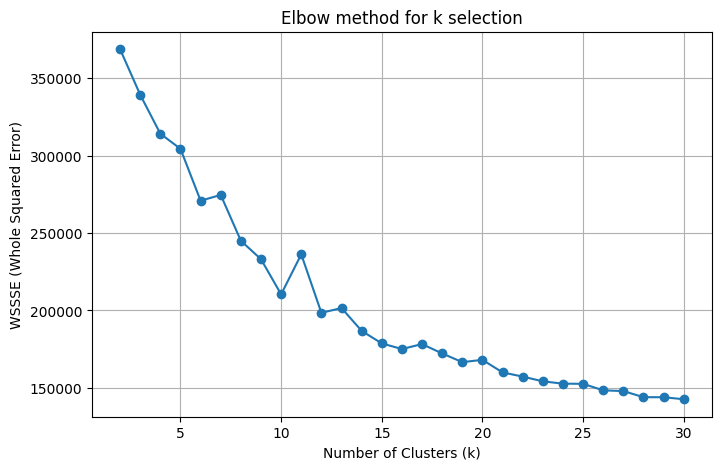

In [12]:
import matplotlib.pyplot as plt

cost = []
ks = list(range(2, 31))

for k in ks:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(df_prepared)
    wssse = model.summary.trainingCost
    cost.append(wssse)
    print(f"K={k} -> WSSSE={wssse:.2f}")

plt.figure(figsize=(8,5))
plt.plot(ks, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE (Whole Squared Error)')
plt.title('Elbow method for k selection')
plt.grid(True)
plt.show()

In [13]:
from pyspark.ml.clustering import KMeans
k=10
kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(df_prepared)
df_clustered = kmeans_model.transform(df_prepared)
df_clustered.select("features", "cluster").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|features                                                                                                                                                                                                                                                                 |cluster|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[1.9134758100760272,-0.14413619829615387,0.10391305514575644,-0.3481097733063079,-0.16706288859734217,-0.35340339299299345,-0.7030605487269814,-0.23293985821957783,0.03067

In [14]:
df_clustered.groupBy("cluster").count().orderBy("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 8580|
|      1| 2816|
|      2|  846|
|      3| 5306|
|      4|  159|
|      5| 1436|
|      6| 7729|
|      7| 1245|
|      8| 2842|
|      9| 1602|
+-------+-----+



In [18]:
df_clustered = df_clustered.withColumnRenamed("cluster", "label_cluster")
df_clustered.select("features", "label_cluster").show(5)

+--------------------+-------------+
|            features|label_cluster|
+--------------------+-------------+
|[1.91347581007602...|            1|
|[0.06874107506367...|            6|
|[-0.5461705032737...|            3|
|[-0.5461705032737...|            3|
|[-0.5461705032737...|            0|
+--------------------+-------------+
only showing top 5 rows



In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label_cluster", featuresCol="features", seed=42)

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator = MulticlassClassificationEvaluator(labelCol="label_cluster", predictionCol="prediction", metricName="accuracy")
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).build()
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=42)

cv_model = cv.fit(df_clustered)

### Model Evaluation

In [21]:
df_predictions = cv_model.transform(df_clustered)

accuracy = evaluator.evaluate(df_predictions)
print(f"Average accuracy (cross-validation): {accuracy:.4f}")

Average accuracy (cross-validation): 0.8391


In [22]:
df_predictions.groupBy("label_cluster", "prediction").count().orderBy("label_cluster", "prediction").show(100)

+-------------+----------+-----+
|label_cluster|prediction|count|
+-------------+----------+-----+
|            0|       0.0| 8039|
|            0|       1.0|   22|
|            0|       3.0|   78|
|            0|       6.0|  399|
|            0|       7.0|    1|
|            0|       8.0|   32|
|            0|       9.0|    9|
|            1|       0.0|  180|
|            1|       1.0| 2546|
|            1|       3.0|   54|
|            1|       5.0|    1|
|            1|       6.0|    1|
|            1|       7.0|    4|
|            1|       8.0|   30|
|            2|       0.0|  175|
|            2|       1.0|   45|
|            2|       2.0|   89|
|            2|       3.0|  136|
|            2|       6.0|  255|
|            2|       7.0|   17|
|            2|       8.0|  112|
|            2|       9.0|   17|
|            3|       0.0|  169|
|            3|       1.0|  107|
|            3|       3.0| 4406|
|            3|       6.0|  601|
|            3|       8.0|    4|
|         

In [23]:
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label_cluster", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label_cluster", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label_cluster", predictionCol="prediction", metricName="recallByLabel")
num_classes = df_predictions.select("label_cluster").distinct().count()

for i in range(num_classes):
    precision = evaluator_precision.evaluate(df_predictions, {evaluator_precision.metricLabel: float(i)})
    recall = evaluator_recall.evaluate(df_predictions, {evaluator_recall.metricLabel: float(i)})
    f1 = evaluator_f1.evaluate(df_predictions, {evaluator_f1.metricLabel: float(i)})
    print(f"Class {i}: Precision={precision:.4f} | Recall={recall:.4f} | F1-Score={f1:.4f}")

Class 0: Precision=0.8964 | Recall=0.9369 | F1-Score=0.8238
Class 1: Precision=0.8856 | Recall=0.9041 | F1-Score=0.8238
Class 2: Precision=0.9889 | Recall=0.1052 | F1-Score=0.8238
Class 3: Precision=0.7761 | Recall=0.8304 | F1-Score=0.8238
Class 4: Precision=0.0000 | Recall=0.0000 | F1-Score=0.8238
Class 5: Precision=0.9893 | Recall=0.7061 | F1-Score=0.8238
Class 6: Precision=0.7648 | Recall=0.9453 | F1-Score=0.8238
Class 7: Precision=0.9599 | Recall=0.4610 | F1-Score=0.8238
Class 8: Precision=0.8893 | Recall=0.9243 | F1-Score=0.8238
Class 9: Precision=0.8782 | Recall=0.4501 | F1-Score=0.8238


In [24]:
import pandas as pd

metrics = []

for i in range(num_classes):
    precision = evaluator_precision.evaluate(df_predictions, {evaluator_precision.metricLabel: float(i)})
    recall = evaluator_recall.evaluate(df_predictions, {evaluator_recall.metricLabel: float(i)})
    f1 = evaluator_f1.evaluate(df_predictions, {evaluator_f1.metricLabel: float(i)})
    metrics.append((i, precision, recall, f1))

metrics_df = pd.DataFrame(metrics, columns=["Cluster", "Precision", "Recall", "F1-Score"])
metrics_df

,Cluster,Precision,Recall,F1-Score
0,0,0.896409,0.936946,0.823755
1,1,0.885565,0.904119,0.823755
2,2,0.988889,0.105201,0.823755
3,3,0.776114,0.830381,0.823755
4,4,0.000000,0.000000,0.823755
5,5,0.989268,0.706128,0.823755
6,6,0.764786,0.945271,0.823755
7,7,0.959866,0.461044,0.823755
8,8,0.889303,0.924349,0.823755
9,9,0.878197,0.450062,0.823755


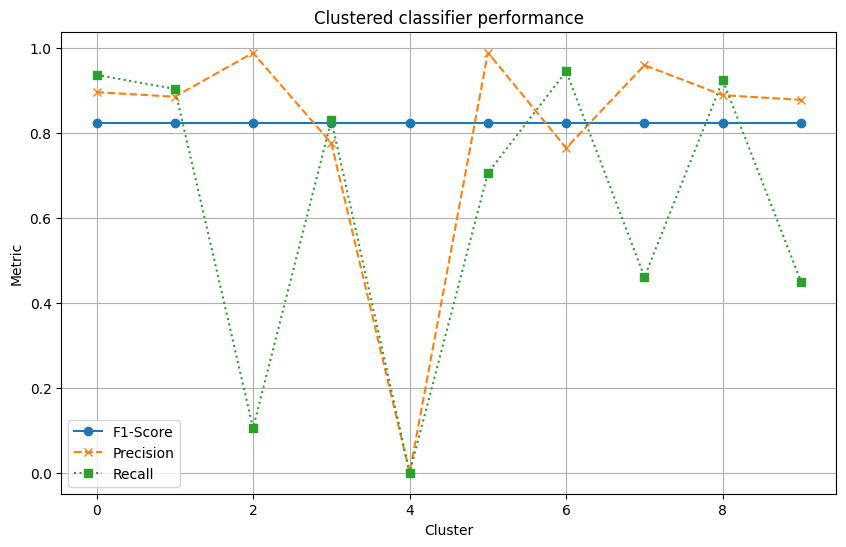

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(metrics_df["Cluster"], metrics_df["F1-Score"], marker='o', label="F1-Score")
plt.plot(metrics_df["Cluster"], metrics_df["Precision"], marker='x', label="Precision", linestyle='--')
plt.plot(metrics_df["Cluster"], metrics_df["Recall"], marker='s', label="Recall", linestyle=':')
plt.xlabel("Cluster")
plt.ylabel("Metric")
plt.title("Clustered classifier performance")
plt.legend()
plt.grid(True)
plt.show()

### Conclusão

Nesta atividade, foi realizado um pipeline completo de análise de dados do censo utilizando tecnologias em nuvem e PySpark:

1. **Pré-processamos** os dados com indexação de variáveis categóricas, montagem de vetores e normalização.
2. **Realizamos agrupamento (KMeans)** e identificamos `k = 10` como o melhor número de clusters via método do cotovelo.
3. **Usamos os clusters como labels** para treinar um classificador supervisionado com Random Forest.
4. **Aplicamos validação cruzada** e analisamos as métricas de performance por cluster.
5. Identificamos **desempenho variado entre os grupos**, com alguns clusters bem modelados e outros com baixo recall ou precisão nula.

**Next Steps**:
- Investigar os clusters com baixa performance (ex: 4 clusters).
- Testar outros classificadores ou ajustes no número de árvores  do modelo Random Forest.
- Explorar técnicas de visualização (como PCA ou t-SNE) para inspeção dos agrupamentos.